# Getting started with **RuNNer**
## Constructing a HDNNP for Bulk Copper

This Jupyter Notebook is written for the RuNNer tutorial at the workshop "WORKFLOWS FOR ATOMISTIC SIMULATION" from 10-12 March, 2021 by **Marius Herbold** (marius.herbold@chemie.uni-goettingen.de, Georg-August-Universität Göttingen, Institut für Physikalische Chemie, Theoretische Chemie).

It is written in text form for an easier understanding, if participants will get back later to this notebook. Anyhow, during the tutorial, we will
not explicitly go through the text.

For this tutorial it is intended to use the RuNNer release version 1.2.
RuNNer is hosted at www.gitlab.com. The most recent version can only be found in this repository.
For access please contact Prof. Jörg Behler (joerg.behler@uni-goettingen.de).

In [1]:
### Import python modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ase
from pyiron import Project

### Import Marius Class and functions
import functions as fc

### Varibales form RuNNer UC
Bohr2Ang = 0.5291772109030   # CODATA 2018
Ang2Bohr = 1/Bohr2Ang
Eh2eV    = 27.211386245988   # CODATA 2018
eV2Eh    = 1/Eh2eV
f_conversion = eV2Eh/Ang2Bohr

# About RuNNer
**RuNNer** is a stand-alone Fortran program for the construction of high-dimensional neural network potentials (HDNNP), written mainly by Jörg Behler. It relates the local environment of an atom to its atomic energy $E_\mathrm{s}$, which contributes to the sum of all $N$ atomic energies, resulting in the total energy of the system $E_\mathrm{s}$

\begin{equation}
    E_\mathrm{s} = \sum_{a}^{N}E_\mathrm{a}.
\end{equation}

The atomic energy is described by an atomic neural network (NN), which is element specific. This gives the oppurtunity to describe different numbers of atoms with the same NN, which would be not the case, if there is only one NN for the whole system. To feed information to the NN, the local environment up to a certain cutoff radius $R_\mathrm{c}$ is described by so-called symmetry functions (SF) (more details are shown in a few moments) forming the SF vector $G$, which forms the input layer of the NN. In the next layers of the NN - the hidden layers - this information will be processed and in the final layer - the output layer - the atomic NN will provide the atomic energy $E_\mathrm{a}$. In each layer, there are a certain number of nodes $y$ which are connected by the weights $a$ and can be biased by the biases $b$. For the NN training the wheights and biases are optimized to represent best the data in the training data set.

![test](NNP1.png)

In general **RuNNer** can be separated into three different stages - so-called modes, in which different steps are performed.
- mode 1: SF calculation, data set splitting in training and test set
- mode 2: training of the NN to construct the NNP
- mode 3: prediction of energy, forces, stress, charges

All these steps are performed consecutively beginning with mode 1. Needed input files are:
* ``input.nn``: 
  - main control file needed in all modes
  - contains all control parameters (NN architecture, symmetry functios, ...)
* ``input.data``:
  - needed in mode 1 and 3
  - contains structural information (lattice vectors, atomic positions, forces, charges, total energy)
  - output of electronic structure code must be converted to ``input.data`` format
  - RuNNer repository provides the RuNNerUC (universial converter) to convert from several formats (FHI-aims, VASP, xyz, LAMMPS) to input.data format and vice-versa

# Getting the First Data Set

Before we are gettinger deeper into **RuNNer**, we will go one step back. At the beginning of each NNP, there is your data set. For sure, the data set does not have to be good/perfect/large, because you can increase your data set step by step and train different generations of your NN, ending up with an accurate potential. For getting your first data set, there are several ways like:
- small random displacements,
- thermal displacements by a simple potential - like force fields - in MD,
- experimental structures.

The question "What is a good data set?" is not that simple to answer and it strongly depends on the purpose of your potential. But one important point is for sure the distribution of your data over the configurational space you like to handle with your potential. If some configurations are missing, the NNP will provide inaccurate results, because you make the NNP predict energies and forces for an unknown configuration. In **RuNNer**, this is called an ``extrapolation``, that means the NNP is not trained to such a configuration.

Here in the workshop, we are dealing with bulk-Cu. So, a first application of your NNP could be to predict the equilibrium lattice constant of bulk-Cu and you will calculate the energy of a bulk-Cu unit cell with different lattice constants to give an energy-volume curve, which provides the equilibrium lattice constant at its minimum. Thus, your data set should contain information of different cell volumes.

Number of points in plot: 8073


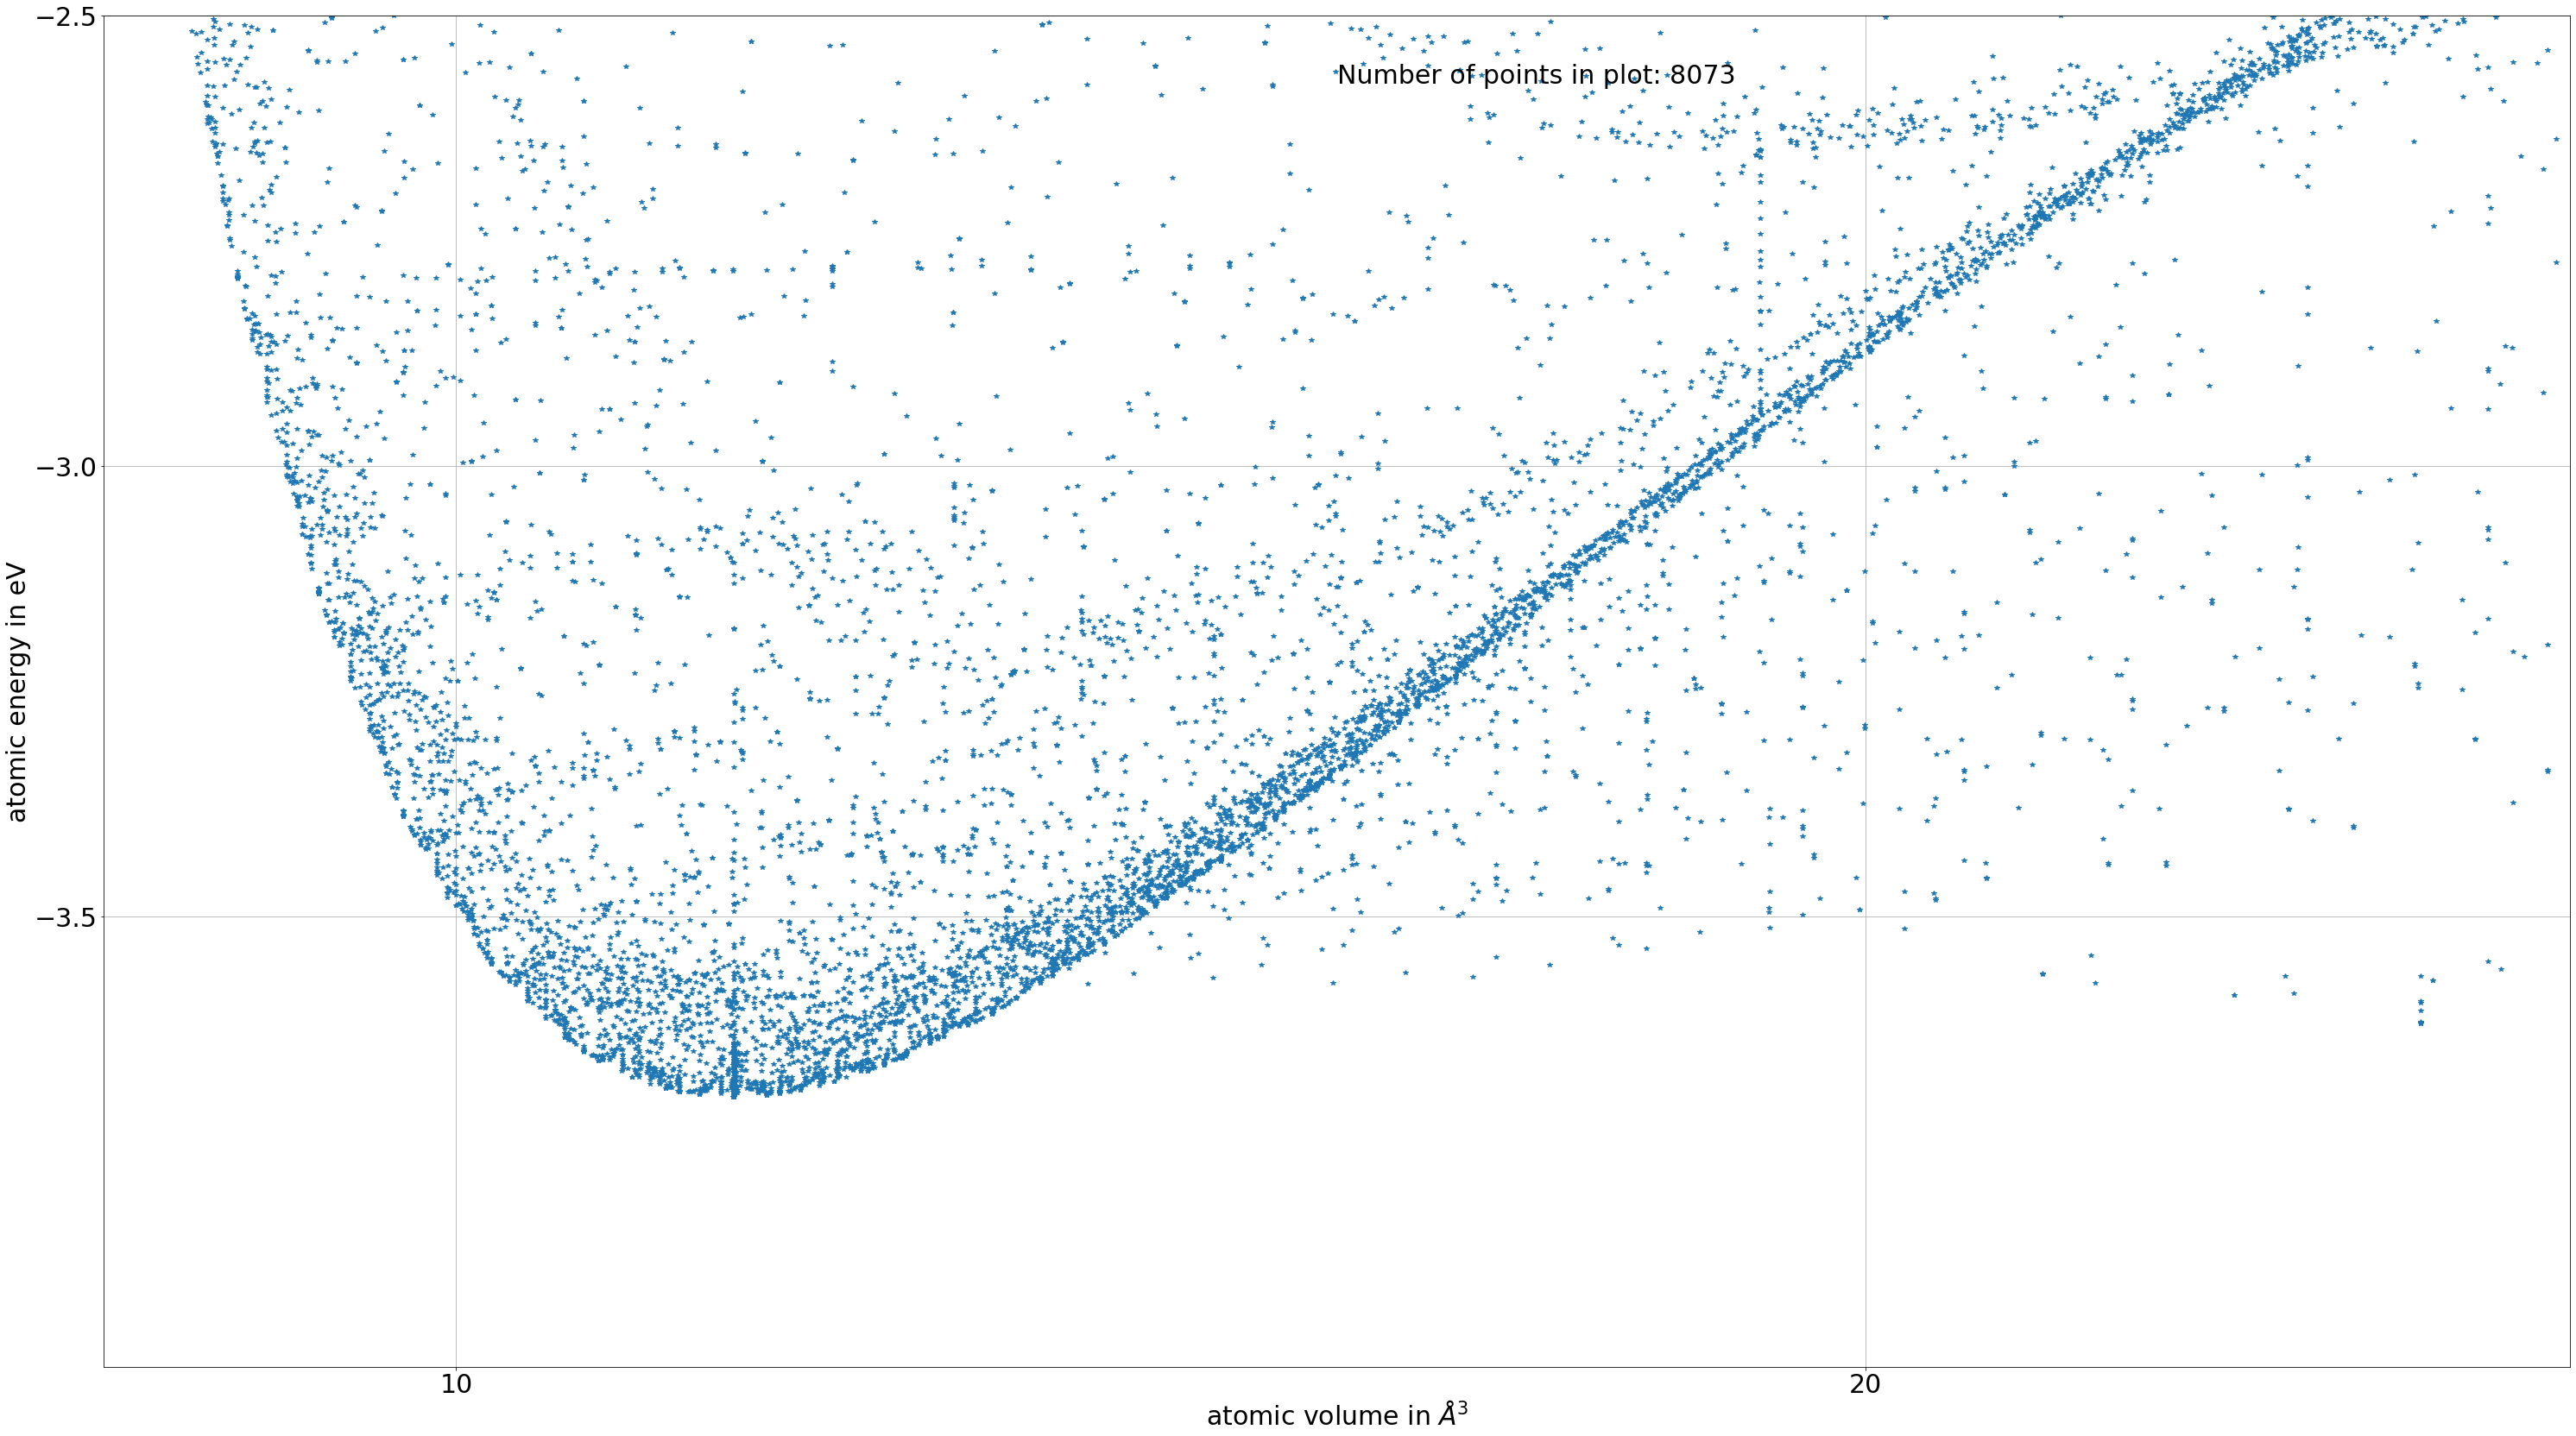

In [2]:
# Read in workshop's data set in pandas data frame
data_pr = Project("../../datasets")
if len(data_pr.job_table()) == 0:
    data_pr.unpack("Cu_training_archive")
data_job = data_pr.load('df4_2_5eV_25A3_8K')
data = data_job.to_pandas()
fig1 = fc.PlotData(data)

As already mentioned, your data needs to be stored in the ``input.data`` file. This file is used for ``mode 1`` to generate all the needed files for the NN training in ``mode 2``. In this case the ``input.data`` stores all the information of the electronic structure code like the total energy and charge, the structure (lattice constants, atomic positions), atomic forces and may the atomic charges. If used in ``mode 3``, only the structural paramteres are necessary, since ``mode 3`` is the prediction mode and we may do not know the outcome of an electronic structure calculation.

The ``input.data`` follows a certain format with certain keywords. Each structure is embedded between the keywords ``begin`` and ``end``, to separate different structures from each other. For periodic structures the three lattice vectors are introduced by the keyword ``lattice``, for non-periodic structures this keyword is just missing. Information about the atoms is given line by line, thus each atom in one line, beginning with the ``atom`` keyword, followed by the Cartesian coordinates (x, y and z), the element, the atomic charge, an unused column and the atomic force components (fx, fy and fz). The ``energy`` keyword is followed by the total energy of the current structure, equivalent, the overall charge is marked by the ``charge`` keyword. Comments can also be added with the ``comment`` keyword. Important aspect: the data is given in special units. A length is given in ``bohr``, an energy in ``Hartree``, thus forces in ``Hartree/bohr`` and charges in the elementary charge ``e``. In general, periodic and non-periodic structures can be mixed, as well as different numbers of atoms per structure can be combined. Information can be given in a free format (number of digits), but it is recommended to use at least six digits and the order of the keywords is arbitrary in general.

# The RuNNer Workflow

We discussed the ``input.data`` and will have a look at the next steps. Here, the ``input.nn`` is explained. Keywords can be given in an arbitrary order, but grouping keywords by the modes is useful for the general structure. The units are the same as for the ``input.data``, see above. If a keyword is not specified, **RuNNer** uses default values, if possible. A summary in the output files give more detailed information in the specific case. Most keywords can only be specified ones, to avoid contradictions, otherwise an error will be printed. Also comments can be added to the file, which are indicated by a hash ``#``. In principle, it is possible to change the ``input.nn`` for every mode, however it is highly recommended not to do that. Anyway here, you will not have the opportunity to explicitly change the ``input.nn``, since **RuNNer** is called via the pyiron environment. At the moment, the implementation of **RuNNer** to pyiron is on a very early stage, thus no changes are possible for the input.

In the following we will discuss a subset, but the most important keywords. Beginning with some general keywords of the ``input.nn``. I think the first keywords are self-explanatory together with the given comments. The data set splitting in ``mode 1`` and the initial weights in ``mode 2`` rely on random numbers. For the reproducibility, a random number seed (keyword ``random_seed``) has to be defined, which will give the same results, if the run is repeated later. Together with this, the generator for the random numbers can also be defined (keyword ``random_number_type``). The second group of keywords describe the architecture of the NN and the activation functions of the nodes via the keywords ``global_...``. Usually, we use 2-3 hidden layers with 10-40 nodes each.

# Pyiron RuNNer Fit

Here, you will not have the opportunity to explicitly change the ``input.nn``, since **RuNNer** is called via the pyiron environment. At the moment, the implementation of **RuNNer** to pyiron is on a very early stage, thus no changes are possible for the input.

In [3]:
pr = Project("runner_fit")

In [4]:
data_pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,1,finished,None,df1_A1_A2_A3_EV_elast_phon,/df1_A1_A2_A3_EV_elast_phon,/home/pyiron/,datasets/Cu_database/,2021-02-18 19:49:53.061360,None,None,zora@cmti001#1,TrainingContainer,0.4,None,None
1,2,finished,None,df3_10k,/df3_10k,/home/pyiron/,datasets/Cu_database/,2021-02-18 19:49:55.496691,None,None,zora@cmti001#1,TrainingContainer,0.4,None,None
2,3,finished,None,df2_1k,/df2_1k,/home/pyiron/,datasets/Cu_database/,2021-02-18 19:49:56.101883,None,None,zora@cmti001#1,TrainingContainer,0.4,None,None
3,4,finished,None,df4_2_5eV_25A3_8K,/df4_2_5eV_25A3_8K,/home/pyiron/,datasets/Cu_database/,2021-02-18 19:49:57.547918,None,None,zora@cmti001#1,TrainingContainer,0.4,None,None


In [5]:
j = pr.create.job.RunnerFit('fit', delete_existing_job=False)

In [6]:
# Be aware of fitting a larger data set, since it will run some time, roughly six hours!
j.add_job_to_fitting(data_pr.load('df1_A1_A2_A3_EV_elast_phon'))

In [7]:
j.run()

The job fit was saved and received the ID: 68


In [8]:
j.lammps_potential

,Name,Filename,Model,Species,Config
0,RuNNer-Cu,"[/home/pyiron/day_2/02-runner/runner_fit/fit_hdf5/fit/input.nn, /home/pyiron/day_2/02-runner/runner_fit/fit_hdf5/fit/weights.029.data, /home/pyiron/day_2/02-runner/runner_fit/fit_hdf5/fit/scaling....",RuNNer,[Cu],"[pair_style nnp dir ""./"" showew no showewsum 0 resetew no maxew 100 cflength 1.8897261328 cfenergy 0.0367493254 emap ""1:Cu""\n, pair_coeff * * 12\n]"


The data set, you will fit is a strongly reduced subset of the data shown above. For comparison, the same plot is shown here.

**Be aware of fitting a larger data set, since it will run some time, roughly six hours!**

Number of points in plot: 105


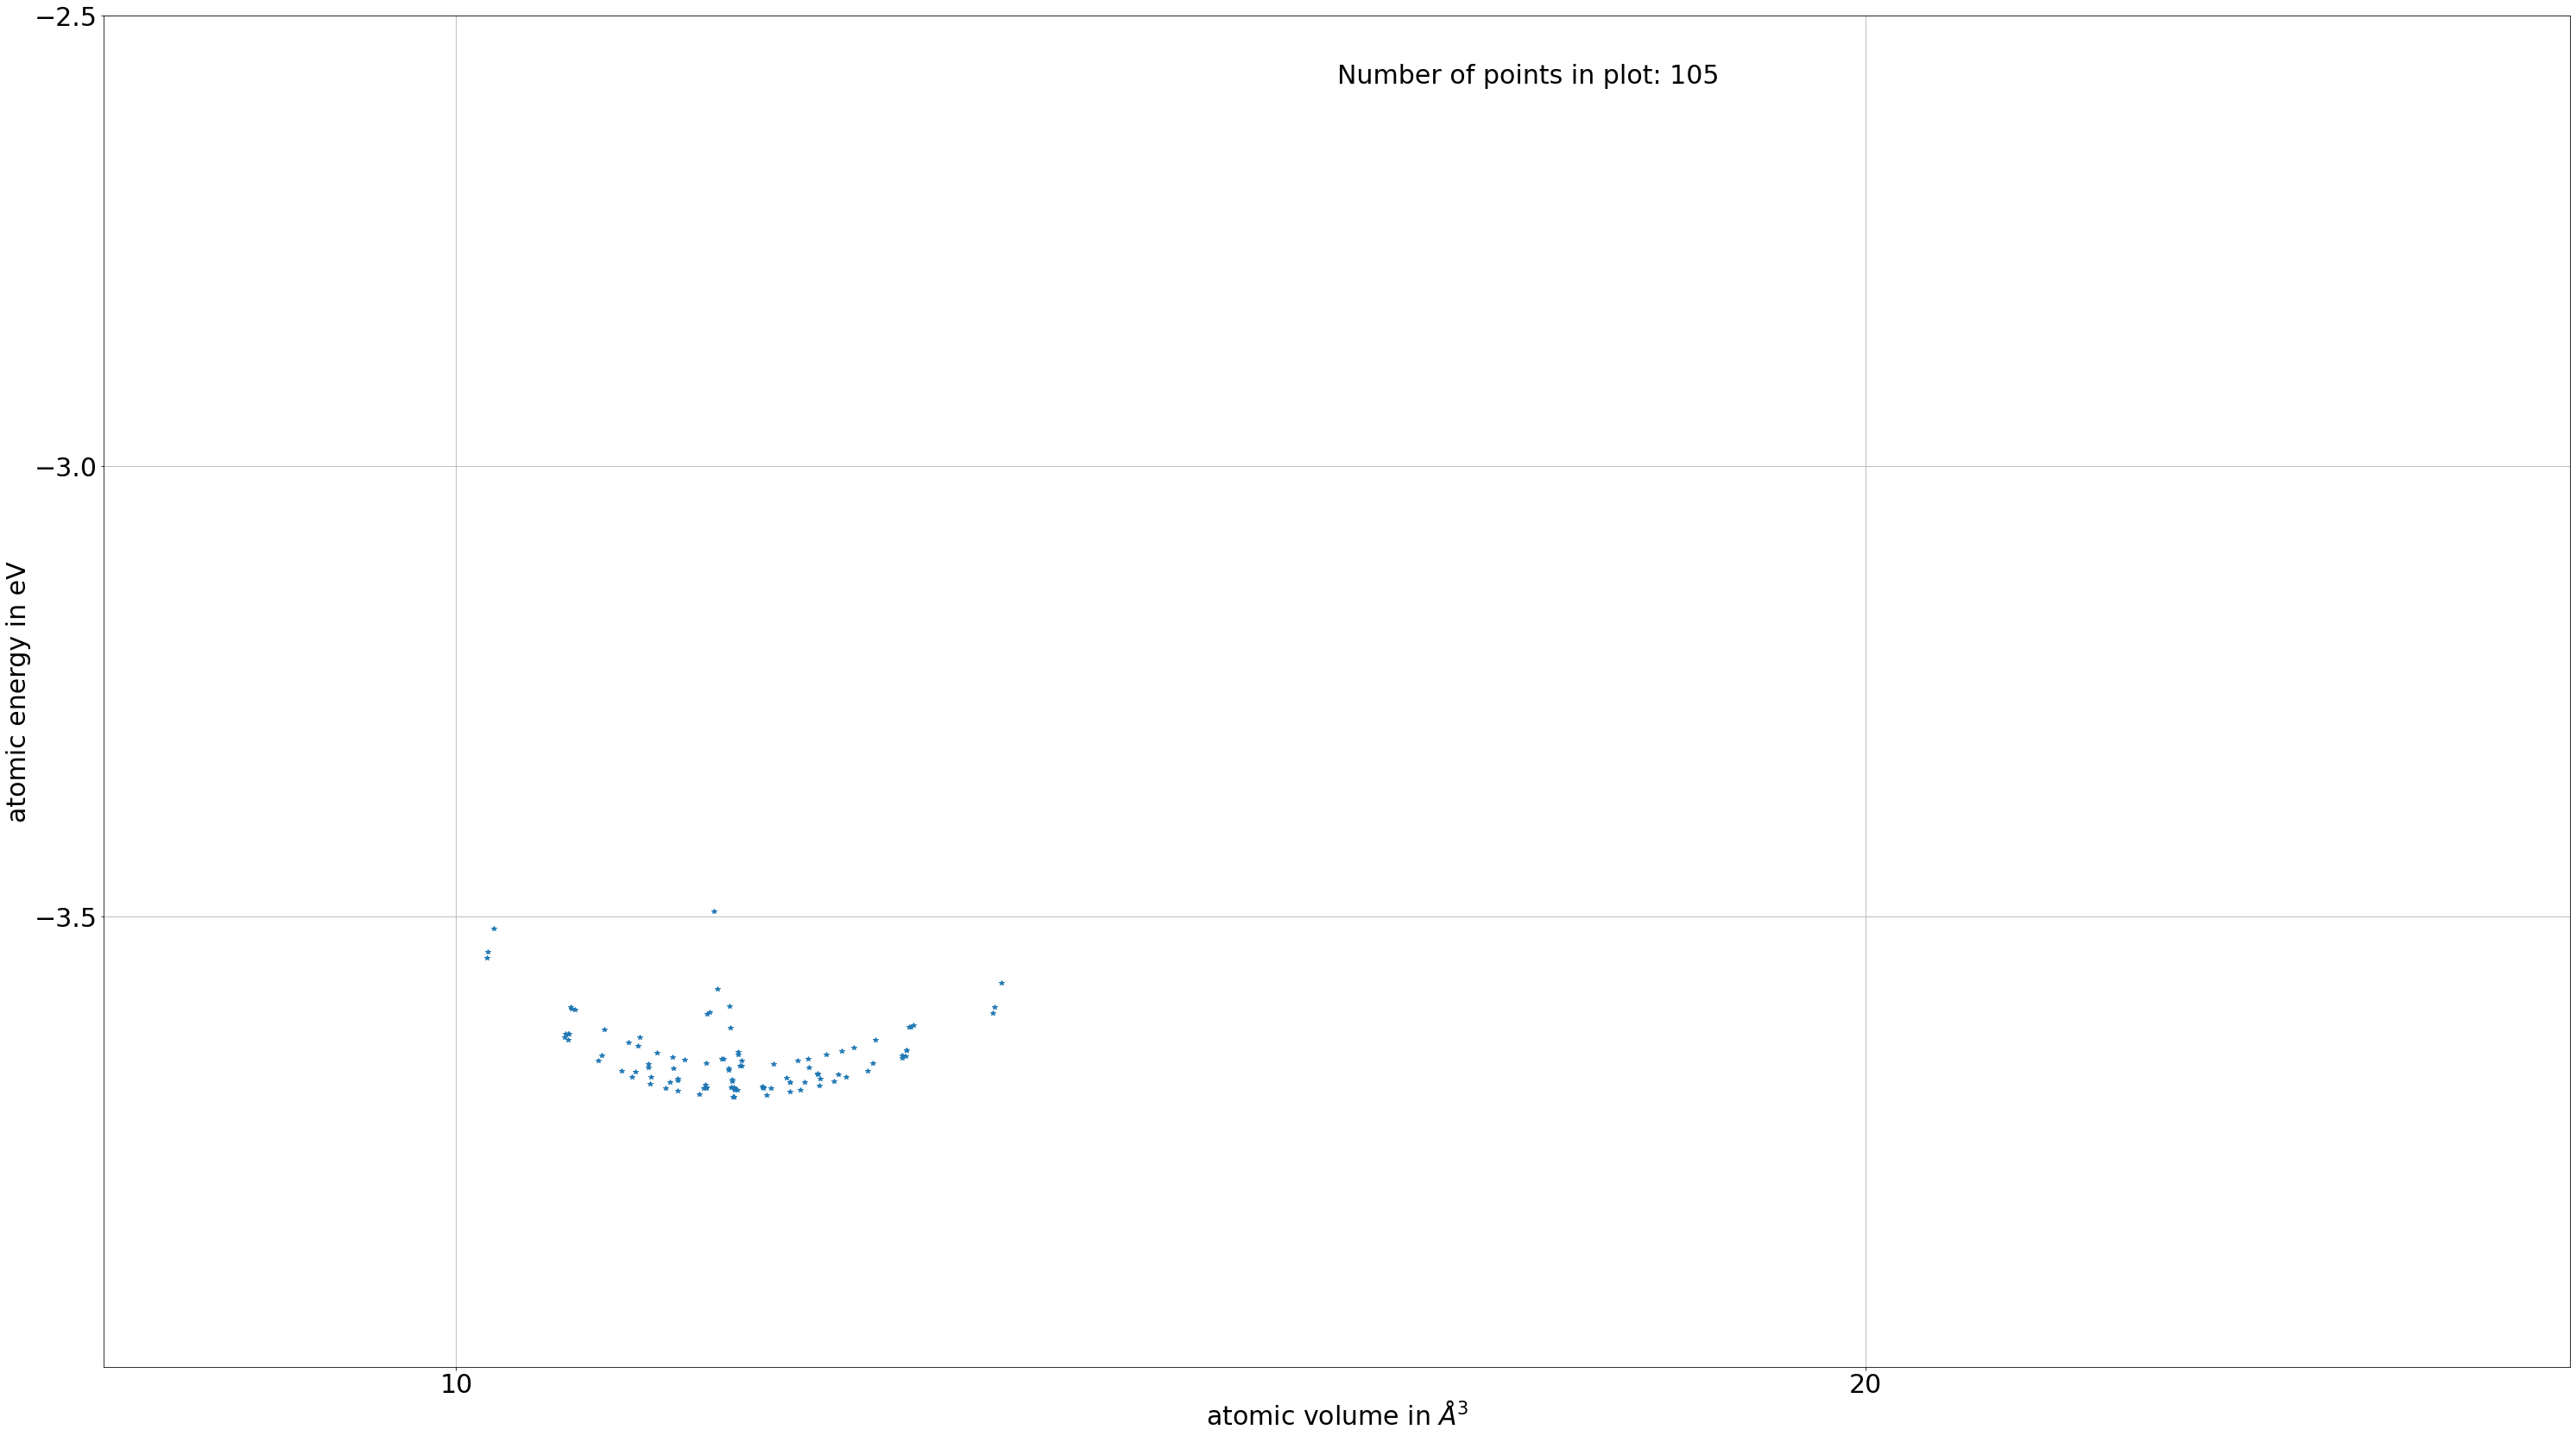

In [9]:
df1_job = data_pr.load('df1_A1_A2_A3_EV_elast_phon')
df1 = df1_job.to_pandas()
fig1 = fc.PlotData(df1)

## RuNNer Mode 1

In **RuNNer**'s mode 1 the following steps are performed:
- calculation of SF values,
- splitting of data set in train and test data set.

The amount of test structures is defined by the keyword ``test_fraction``. Here, ``test_fraction 0.10`` means 10% of the data set will be used for testing and is not part of the training data. ``use_short_forces`` keyword states to use also the atomic forces for the fitting process in ``mode 2``, but it is recommended to use it also in ``mode 1`` to create the necessary force files.

In the next group of keywords, the SFs are defined. There are two different types of SFs: the radial SFs ``symfunction_short XX type XX ...`` to describe the atomic distances and angular SFs ``symfunction_short XX type XX XX ...`` to describe the spatial distribution of the neighboring atoms. ``cutoff_type`` keyword describes the cutoff function type. All mentioned SF types are shown in the next section.

### Definition of the Symmetry Functions (SFs)

Different types of SFs for the radial and angular SFs are implemented in **RuNNer**, but only the most common types are shown here. SFs provide the input for the NN and describe the local atomic environment of each atom and are rotationally and translationally invariant. So, SFs describe the relative positions of the atoms to each other. In contrast, Cartesian coordinates describe the absolute positions to each other and change with a translation or a rotation. That means the numerical input will change with translation or rotation, but not the energy of the system. However, different numerical inputs belonging to the same energy leads to problems in fitting.

### The Cutoff Function

Another kind of symmetry function is the cutoff function, which is included in the radial and angular SFs. The cutoff radius $R_\mathrm{c}$ (usually $12\,\mathrm{bohr}$) defines how much of the local atomic environment is considered. All SFs will decrease to zero, if the atomic distance is larger than $R_\mathrm{c}$. A decrease to exact zero is necessary for numerical reasons. There are several cutoff funtions defined in **RuNNer** and we will use here

\begin{equation}
    f_{c}(R_{ij}) = 
    \begin{cases}
    1& ~ \text{for $R_{ij} \leq R_{inner,c}$}\\
    0.5 * [cos(\pi x) + 1]& ~ \text{for $R_{inner,c} \leq R_{ij} \leq R_\mathrm{c}$},\\
    0& ~ \text{for $R_\mathrm{c} < R_{ij}$}
    \end{cases}
\end{equation}

with the atomic distance $R_{ij}$, the cutoff radius $R_\mathrm{c}$, the inner cutoff $R_{inner,c}$ (here $=0$) and $x = \frac{R_{ij} - R_{inner,c}}{R_\mathrm{c} - R_{inner,c}}$.

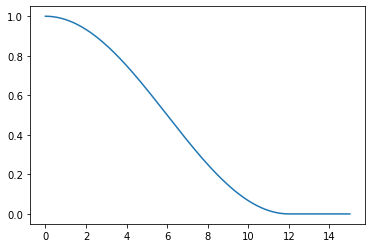

In [10]:
distances = np.arange(0,15.1,0.1)
cfct = np.array([fc.cutofffct(i) for i in distances])
plt.plot(distances, cfct);

### The Radial Symmetry Functions

To define the parameters for the radial SFs, it is important to know which are the shortest bonds in your data set. Usually, 5-6 radial SF are used for each element pair, with different $\eta$ values to increase the resolution for structure description. It is possible to shift the maximum of the radial SF $G^2$ by $R_{s}$

\begin{equation}
    G_{i}^{2} = \sum_{j}^{}e^{\eta (R_{ij} - R_{s})^2} \cdot f_{c}(R_{ij}).
\end{equation}

Below, the defintion of a radial SF in ``input.nn``, again ``symfunction_short`` calls to define a SF, ``Cu`` defines the specific element, ``2`` the SF type, the second ``Cu`` defines the neighboring atom, and the last three parameters define $\eta$, $R_{s}$ and $R_\mathrm{c}$. The gaussian exponent $\eta$ for the radial SF are chosen to equally distribute the radial SF turning points, whereas the turning point of radial SF with $\eta = 0$ is set to the specific minimum bond in your data set. There is no need to define element specific SF, also global SF are possible, which are used for every element combination. It is also possible to define for each SF a different $R_\mathrm{c}$, but it is recommended to use only one $R_\mathrm{c}$ for all SFs.   

Here, different radial parts of radial SFs with different $\eta$ are plotted. Feel free and play around with the parameters.

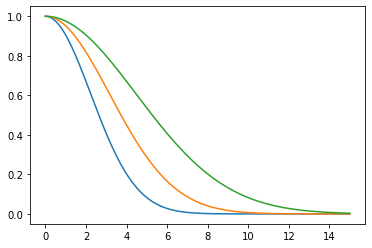

In [11]:
rsf1 = np.array([fc.radialSF(i, 0.1) for i in distances])
rsf2 = np.array([fc.radialSF(i, 0.05) for i in distances])
rsf3 = np.array([fc.radialSF(i, 0.025) for i in distances])
plt.plot(distances, rsf1[:,1], label='');
plt.plot(distances, rsf2[:,1], label='');
plt.plot(distances, rsf3[:,1], label='');

### The Angular Symmetry Functions

For the angular SF it is quite similar as for the radial SF. But here, three atomic positions are included.

\begin{equation}
    G_{i}^{3} = 2^{\zeta - 1}\sum_{j}^{} \sum_{k}^{} \left[( 1 + \lambda \cdot cos \theta_{ijk})^{\zeta} \cdot e^{\eta (R_{ij}^2 + R_{ik}^2 + R_{jk}^2)} \cdot f_{c}(R_{ij}) \cdot f_{c}(R_{ik}) \cdot f_{c}(R_{jk}) \right],
\end{equation}

the angle $\theta_{ijk} = \frac{\mathbf{R}_{ij} \cdot \mathbf{R}_{ik}}{R_{ij} \cdot R_{ik}}$ is centered at atom $i$ and the atomic distance vector is defined as $\mathbf{R}_{ij} = \mathbf{R}_{i} - \mathbf{R}_{j}$. Mostly used for the angular exponent $\zeta = 1, 2, 4 ,16$, gaussian exponent $\eta = 0$ and for $\lambda$ only $+1$ or $-1$ is possible. If many atoms of each element are present, angular SFs are usually not critical and a default set of SFs can be used.

Here a definition of an angular SF is given, which is similar to the definition of a radial SF. ``3`` defines the used type of SF, which needs the following parameters: ``Cu Cu`` to describe the neighboring atoms included in the angle, followed by $\eta$, $\lambda$, $\zeta$ and $R_\mathrm{c}$.

Below, you find different angular parts for angular SF with different $\zeta$ and $\lambda$ values. Fell free and play around.

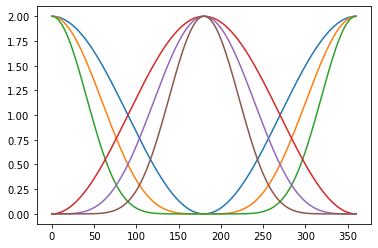

In [12]:
angles = range(0,361)
asf1 = np.array([fc.angularSF(i,1,1,1,0.0,1.0,1.0) for i in angles])
asf2 = np.array([fc.angularSF(i,1,1,1,0.0,1.0,2.0) for i in angles])
asf3 = np.array([fc.angularSF(i,1,1,1,0.0,1.0,4.0) for i in angles])
asf4 = np.array([fc.angularSF(i,1,1,1,0.0,-1.0,1.0) for i in angles])
asf5 = np.array([fc.angularSF(i,1,1,1,0.0,-1.0,2.0) for i in angles])
asf6 = np.array([fc.angularSF(i,1,1,1,0.0,-1.0,4.0) for i in angles])
plt.plot(angles, asf1[:,1]);
plt.plot(angles, asf2[:,1]);
plt.plot(angles, asf3[:,1]);
plt.plot(angles, asf4[:,1]);
plt.plot(angles, asf5[:,1]);
plt.plot(angles, asf6[:,1]);

### Output Mode 1

As said, the data set splitting and the calculation of the symmetry function values takes place here. Among general information of your data set and your SFs, you find explicitly how the data set is splitted. As shown in the example below, it is written what happens to each structure (called ``Point``) and if it goes to the training or test set and which number it has there. ``mode 1`` will prepare the necessary files for ``mode 2``:
* training data
 - function.data: SF values for each atom in each structure
 - trainstruct.data: structural information
 - trainforces.data: force information (if force fitting is used)
 

* test data
 - testing.data: SF values for each atom in each structure
 - teststruct.data: structural information
 - testforces.data: force information (if force fitting is used)

**RuNNer** ends without any problems, if at the end of the ouput file the following lines are written:

### Short quick example of SF calculation

To clarify how the SFs represent the atomic environment for an atom. Let's have a look at this simple structure with three Cu atoms below:

Here we define the atomic positions as vectors, calculate  the distances and angles for the SFs. Finally, we will end up with the SFs vector for the first Cu atom. We use the 13 SFs, which were introduced in the section above "RuNNer Mode 1".

In [13]:
# Define atomic positions as vectors
d1 = np.array([0.0, 0.0, 0.0])
d2 = np.array([0.0, 0.0, 6.72752138])
d3 = np.array([2.34735543, 1.35524733, 3.36375974])

# Define distance vectors
d12 = d1 - d2
d13 = d1 - d3
d23 = d2 - d3

# Define angles
a123 = np.dot(d12, d13) / (np.linalg.norm(d12) * np.linalg.norm(d13))
a213 = np.dot(d12, d23) / (np.linalg.norm(d12) * np.linalg.norm(d23))
a312 = np.dot(d13, d23) / (np.linalg.norm(d13) * np.linalg.norm(d23))

# Calculate radial symmetry function values
for eta in [0.000, 0.006, 0.016, 0.040, 0.109]:
    value_sf = 0
    for d in [d12, d13]:
        d = np.linalg.norm(d)
        value_sf += fc.radialSF(d, eta)[0]
    print(value_sf)

# Calculate angular symmetry function values
for Lambda in [1, -1]:
    for zeta in [1, 2, 4, 16]:
        for a in [a123]:
            value_sf = fc.angularSF(a, np.linalg.norm(d12), np.linalg.norm(d13), np.linalg.norm(d23), 0.0, Lambda, zeta)[0]
        print(value_sf)
        

1.1182423115740479
0.9463318326255568
0.7253600030997174
0.40425285668735783
0.09616369636385737
0.411992195819298
0.4119731729121053
0.41193512973271224
0.41170694441910877
1.9023785577599554e-05
8.78384860610243e-10
1.872667361071411e-18
1.7583909381106493e-70


## RuNNer Mode 2

In ``mode 2``, the magic happens and your data will be fitted. The part below of the ``input.nn`` defines how the fitting in ``mode 2`` has to take place. ``epochs`` define how often **RuNNer** will loop over the training data to optimize the weights and biases of the NN, ``fitting_unit`` defines in which unit the output will be presented in ``mode 2``, all other files and units will stay in ``bohr`` and ``Hartree``. ``precondition_weights`` effects the initial weights and biases of the NN. In the second part, there are some parameters for the Kalman-Filter, ``repeated_energy_update`` repeats the energy update after a force component update, to increase the impact of the energies. This is slower in general, but might be necessary, since there a many more force components than energies. ``mix_all_points`` mixes the order of the training points for each epoch to improve the training. Often, the ranges of the symmetry functions are rather different in their order of magnitude and thus a rescaling of SFs can be advantageous numerically stated by ``scale_symmetry_functions`` keyword. Together with that, a centering of the SF average value to zero is performed for numerical reasons, since zero is the non-linear center of most activations  functions. ``short_force_fraction`` defines how much of the force components is randomly used for training the NN. The last part, defines to write certain files for each epoch, to analyze it in a later stage. There are many other keywords and options to present. However, you got an idea how **RuNNer** works and what to do to fit your first NNP. In the next part, first steps for analyzing the fit are presented.

During the fitting process of the NN, the error function $\Gamma$ is minimized, which is defined as 
\begin{equation}
    \Gamma = \frac{1}{N_\mathrm{struct}} \sum_{i}^{N_\mathrm{struct}} (E_{NN}^{i} - E_{Ref}^{i})^2 = RMSE(E),
\end{equation}
if only energy fitting is used, which defines simultaneously the root-mean squared error of the energies $RMSE(E)$. This defines the differences of the reference data and the NNP predictions. During the epochs, the error decreases as you can see in the part of ``mode2`` output.

A first and simple plot to anlyze the progress of the fitting procedure, is to show the RMSEs over the epochs. Here, you can easily identify overfitting, if the training $RMSE$ is much lower than the test $RMSE$, for example.
Anyhow, the $RMSE$ is a rather strong reduction of the really complex potential energy surface (PES) and can only be understood as a rule of thumb for the quality of the NNP fit.

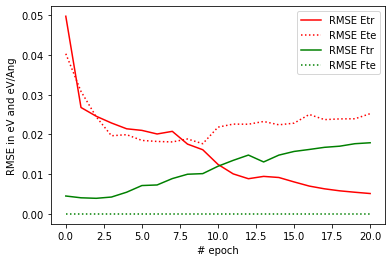

In [14]:
# Load here an example fit
# Use results of the workshop participants
fit2 = fc.RuNFit('runner_fit/fit_hdf5/fit', 9)
#fit2 = fc.RuNFit('MH-df4-2', 7)
figRMSE = fit2.plot_rmse()

For a more detailed analyze, you could have a look at the predicted energies and forces per structure. This is quite useful to identify inaccurately described structures. The training data set may has a specific order of different structures (bulk, slab, cluster, ...) and you can identify, if some parts of the data set are described inaccurately in general. The second plot shows the atomic energy prediction of the NNP over the reference values. For a perfect fit, all points will be on the blue line, but as we can see this is not the case. In this plot, we can identify, if some energies ranges are not well described in our data set. This is related to our first data set analysis above.

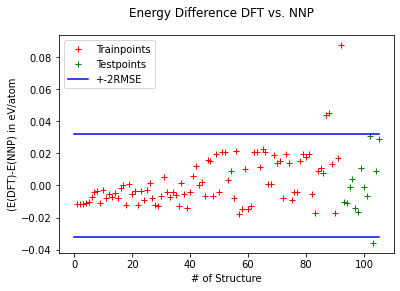

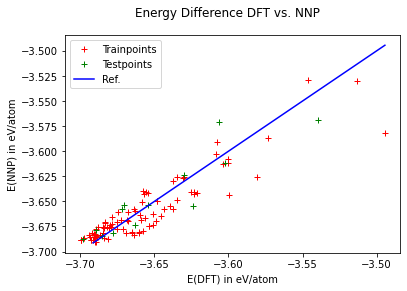

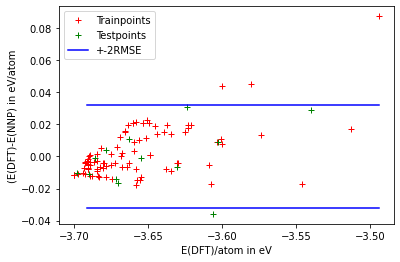

In [15]:
figE1, figE2, figF3 = fit2.plot_points()

The same plot can also be done for the atomic forces.

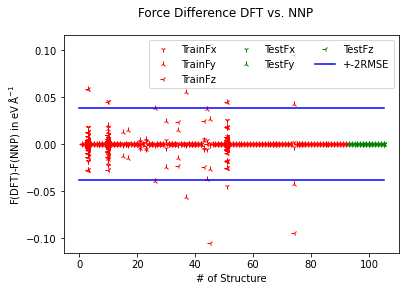

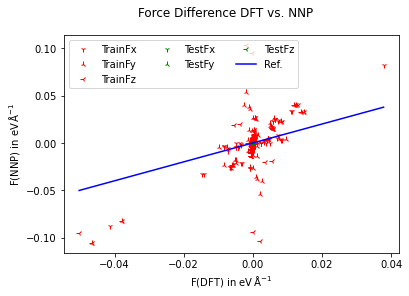

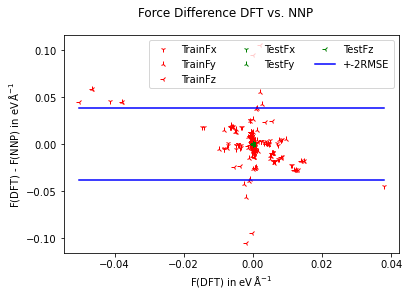

In [16]:
figF1, figF2, figF3 = fit2.plot_forces()

The ``mode 2`` output gives further information about the parameters of the fitting procedure, about the fitting data and it gives information about the defined SFs and the SFs ranges. These ranges define the known configuration space of your NNP and are used to identify the already mentioned ``extrapolations``. If the NNP is made to predict energies, forces or stress, it first calculates the SF vectors and compares these values to the trainings range shown below. If a SF value occurs, which is not in the range, **RuNNer** will give an ``extrapolation warning`` and tell the user, but you will still get your wanted energy, force or stress. Another usage of these ranges is to increase the data set and the known configuration space.

During ``mode 2`` several files will be printed by **RuNNer** and some are printed every epoch:
- scaling.data: information about the SFs if ``scale_symmetry_functions`` is used
- xxxxxx.XXX.out: weights and biases of the specific epoch xxxxxx for atomic NN of element XXX
- optweights.XXX.out: weights and biases of the epoch with lowest RMSE defined by **RuNNer** for element XXX
- trainpoints.xxxxxx.out, testpoints.xxxxxx.out: optional, giving information about training and test energies of epoch xxxxxx
- trainforces.xxxxxx.out, testforces.xxxxxx.out: optional, giving information about training and test forces of epoch xxxxxx

## RuNNer Mode 3

**RuNNer** ``mode 3`` is the prediction mode and brings the NNP to application. Via N2P2, NNP can also be used in LAMMPS. For ``mode 3``, the ``input.nn``, ``scaling.data`` (if scaling is used), ``weights.XXX.data`` and the ``input.data``, contaning the structures to predict, are needed. A first application of the NNP in the Cu case is to predict the correct energy-volume behaviour.

In [17]:
pr_ev = pr.create_group("E_V_curve") # Creating a new sub-project within the main project
a_list = np.linspace(3.4, 4.0, 7)
for a in a_list:
    job_name = "job_a_{:.4}".format(a).replace(".", "_")
    job = pr_ev.create.job.Lammps(job_name, delete_existing_job=False)
    job.structure = pr_ev.create_ase_bulk("Cu", a=a)
    #job.potential = '2012--Mendelev-M-I--Cu--LAMMPS--ipr1'
    job.potential = j.lammps_potential
    job.calc_minimize()
    job.run()

The job job_a_3_4 was saved and received the ID: 69
The job job_a_3_5 was saved and received the ID: 70
The job job_a_3_6 was saved and received the ID: 71
The job job_a_3_7 was saved and received the ID: 72
The job job_a_3_8 was saved and received the ID: 73
The job job_a_3_9 was saved and received the ID: 74
The job job_a_4_0 was saved and received the ID: 75


In [18]:
pr_ev.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,69,finished,Cu,job_a_3_4,/job_a_3_4,/home/pyiron/,day_2/02-runner/runner_fit/E_V_curve/,2021-03-09 09:12:11.908333,2021-03-09 09:12:12.233260,0.0,pyiron@jupyter-janssen#1,Lammps,0.1,None,None
1,70,finished,Cu,job_a_3_5,/job_a_3_5,/home/pyiron/,day_2/02-runner/runner_fit/E_V_curve/,2021-03-09 09:12:12.600059,2021-03-09 09:12:12.930932,0.0,pyiron@jupyter-janssen#1,Lammps,0.1,None,None
2,71,finished,Cu,job_a_3_6,/job_a_3_6,/home/pyiron/,day_2/02-runner/runner_fit/E_V_curve/,2021-03-09 09:12:13.308590,2021-03-09 09:12:13.628758,0.0,pyiron@jupyter-janssen#1,Lammps,0.1,None,None
3,72,finished,Cu,job_a_3_7,/job_a_3_7,/home/pyiron/,day_2/02-runner/runner_fit/E_V_curve/,2021-03-09 09:12:14.004092,2021-03-09 09:12:14.332162,0.0,pyiron@jupyter-janssen#1,Lammps,0.1,None,None
4,73,finished,Cu,job_a_3_8,/job_a_3_8,/home/pyiron/,day_2/02-runner/runner_fit/E_V_curve/,2021-03-09 09:12:14.709127,2021-03-09 09:12:15.039564,0.0,pyiron@jupyter-janssen#1,Lammps,0.1,None,None
5,74,finished,Cu,job_a_3_9,/job_a_3_9,/home/pyiron/,day_2/02-runner/runner_fit/E_V_curve/,2021-03-09 09:12:15.413618,2021-03-09 09:12:15.737637,0.0,pyiron@jupyter-janssen#1,Lammps,0.1,None,None
6,75,finished,Cu,job_a_4_0,/job_a_4_0,/home/pyiron/,day_2/02-runner/runner_fit/E_V_curve/,2021-03-09 09:12:16.124528,2021-03-09 09:12:16.435324,0.0,pyiron@jupyter-janssen#1,Lammps,0.1,None,None


In [19]:
def get_volume(job):
    return job["output/generic/volume"][-1]
def get_energy(job):
    return job["output/generic/energy_tot"][-1]

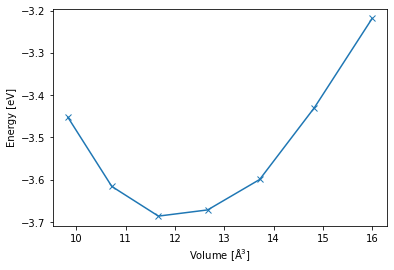

In [20]:
# Analysing the data
vol_list = list()
energy_list = list()

for job in pr["E_V_curve"].iter_jobs(status="finished"):
    vol_list.append(get_volume(job))
    energy_list.append(get_energy(job))

args = np.argsort(vol_list)
vol_list = np.array(vol_list)
energy_list = np.array(energy_list)
plt.plot(vol_list[args], energy_list[args], "-x")
plt.xlabel("Volume [$\mathrm{\AA^3}$]")
plt.ylabel("Energy [eV]");